# Get values of gridded data at location of lines and points

This notebook shows how `poligrain` and its classes `GridAtPoint` and `GridAtLine` can be used to get data from a gridded products, e.g. weather radar data, at specific points or averaged along specific lines.

The radar data processing package `wradblib` solves this case for gridded data and points, but was not easily extentable for working with line geometries. Hence, in `poligrain` we reuse the `wradlib` appraoch for points and implement, with a similar API, the case where we get gridded data along lines.

In [1]:
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt

## Load example data from OpenMRG

We use the gauge, radar and CML data provided by the OpenMRG dataset, see Andersson et al. 2022 https://doi.org/10.5194/essd-14-5411-2022

Here we only look at a small subest. 

Note that the CML data was processed with the simple standard processing done [here](https://github.com/OpenSenseAction/merging_prototype/blob/9cd018be263a8f5ae38bb28c1f768b353d97ffbc/radar_cml_gauge_merge_prototype.ipynb). CML data quality can be further improved with more sophisticated processing methods. For more details and an overview of methods, please refer to [`pycomlink`](https://github.com/pycomlink/pycomlink)

In [2]:
ds_cmls = xr.open_dataset('data/openMRG_cmls_20150827_12hours.nc')

ds_city_gauges = xr.open_dataset('data/openMRG_city_gauges_20150827.nc')
ds_city_gauges = ds_city_gauges.rename_dims({'station_id': 'id'})

ds_radar = xr.open_dataset('data/openMRG_example_rad_20150827_90minutes.nc')
ds_radar.coords['lat'] = ds_radar.lat
ds_radar.coords['lon'] = ds_radar.lon

We remove very short CMLs (< 1 km) and CMLs which have frequencies below 30 GHz combined with a length below 2 km. We do this because these CMLs are fairly insensitive to rainfall and this might provide less accurate rainfall estimates. That is not say, that one cannot use rainfall estimates of these CMLs. But since CML data processing and the analysis of the resulting rainfall estimates is not the focus in this example, we remove the more insensitive CMLs.

We also select only one sublink because here, we are not interesed in comparing or leveraging the information from the two rainfall estimates of the two sublinks that each CML provides.

In [3]:
# Remove some very short CMLs (< 1 km) with frequency below 30 GHz
ds_cmls = ds_cmls.where(~((ds_cmls.length/1000 < 2) & (ds_cmls.frequency/1000 < 30)), drop=True)
ds_cmls = ds_cmls.where(ds_cmls.length/1000 > 1, drop=True).isel(sublink_id=0)

## Quick look at data on a map

Here we first aggregate the rainfall data of all sensors to 1 hour to see the large-scale rainfall pattern

In [4]:
ds_radar_1h = ds_radar.resample(time='h', label='right').mean()
# TODO: Does the city gauge data have a temporal shift??????????
ds_city_gauges_1h = ds_city_gauges.resample(time='h', label='right').sum()
ds_cmls_1h = ds_cmls.R.resample(time='h', label='right').mean()

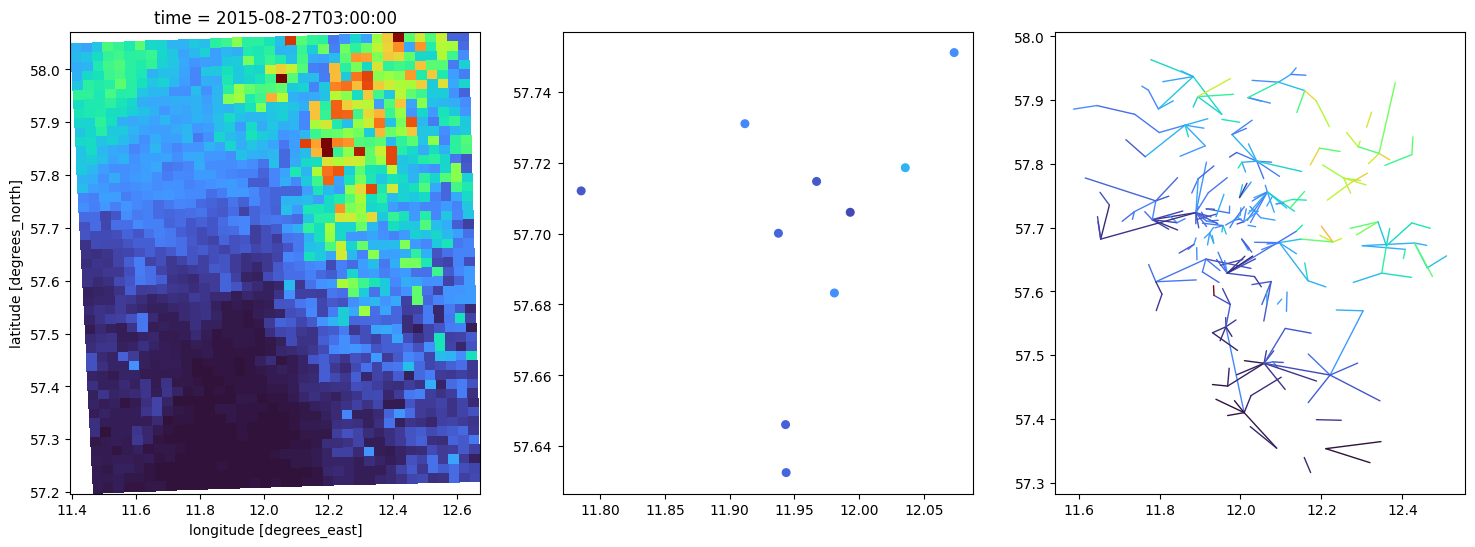

In [5]:
t = '2015-08-27T03:00:00'
vmin = 0
vmax = 10
cmap = 'turbo'

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ds_radar_1h.sel(time=t).rainfall.plot(
    x='lon', y='lat', cmap=cmap, vmin=vmin, vmax=vmax, ax=axs[0], add_colorbar=False)
axs[1].scatter(
    ds_city_gauges.lon, 
    ds_city_gauges.lat, 
    c=ds_city_gauges_1h.sel(time=t).rainfall_amount,
    cmap='turbo', 
    vmin=vmin, 
    vmax=vmax, 
    s=30,
)
ds_cmls_1h.sel(time=t).plg.plot_cmls(
    vmin=vmin,
    vmax=vmax,
    cmap='turbo',
    ax=axs[2]);

## Get radar data at gauge locations

This is an established approach which follows what is done in `wradlib` e.g. via its `wradlib.adjust.RawAtObs` class. In `poligrain` we do, however, make the usage much more easy by using `xarray.DataArray` as input and requiring that `lon` and `lat` variables as 2D grids are present.

First an object of `GridAtPoints` is created which precalculates a `KDTree` for finding the nearest neighboring grid cells for each gauge location. By doing that, the second step, calling `get_grid_at_points`, which is pointing to `GridAtPoints.__call__`, is very fast and can be done later on for other time stamps without much computational cost.

In [6]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar, 
    da_point_data=ds_city_gauges,
    nnear=1,
    stat='best',
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_radar.rainfall, 
    da_point_data=ds_city_gauges.rainfall_amount,
)

radar_at_points.isel(id=0)

<xarray.DataArray (time: 19)>
array([ 0.  ,  0.58,  0.  ,  0.06,  0.29,  0.27,  0.  ,  0.12,  0.36,
       57.79, 16.29,  2.58,  0.92,  1.22,  0.34,  0.06,  0.27,  0.  ,
        0.19])
Coordinates:
  * time     (time) datetime64[ns] 2015-08-27T01:00:00 ... 2015-08-27T02:30:00
    lon      float64 11.94
    lat      float64 57.65

## Get radar data averaged along the CML paths

This follows the same approach as `GridAtPoints` shown above.

First an object of `GridAtLines` is created. At creation time, the grid interseection weights for each CML path are cacluated and stored as sparse matrix (more details on the grid intersection calculation are given in the [this example notebook](Grid_intersection.ipynb)). In the second step we can get the path-averaged grid values at the line locations via `get_grid_at_lines`, which is pointing to `GridAtLines.__call__`, at very low computational cost.

Please note that for large grid size and large number of CMLs, the initialization of `GridAtLines`, with the calculation of the grid intersection weights for each CML path, might take some minutes. For the example data shown here, it takes less then a second, though.

In [7]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar, 
    ds_line_data=ds_cmls,
)

In [8]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_radar.rainfall)
radar_along_cml.isel(cml_id=0)

<xarray.DataArray (time: 19)>
array([ 0.05224049,  0.        ,  0.14822769,  0.02985171,  0.60091528,
        0.31713402,  0.21029207,  0.30182814,  0.31911496, 14.13713966,
       11.01734918,  3.2003317 ,  0.72485403,  4.96016259,  2.89632354,
        0.5640899 ,  0.13471272,  0.21360311,  0.30986111])
Coordinates:
    cml_id        int64 10005
  * time          (time) datetime64[ns] 2015-08-27T01:00:00 ... 2015-08-27T02...
    sublink_id    <U9 'sublink_1'
    site_0_lat    float64 57.69
    site_0_lon    float64 11.95
    site_1_lat    float64 57.7
    site_1_lon    float64 11.96
    frequency     float64 3.236e+04
    polarization  <U1 'v'
    length        float64 1.13e+03

## Plot CML and gauge rain rates vervus the associated radar values

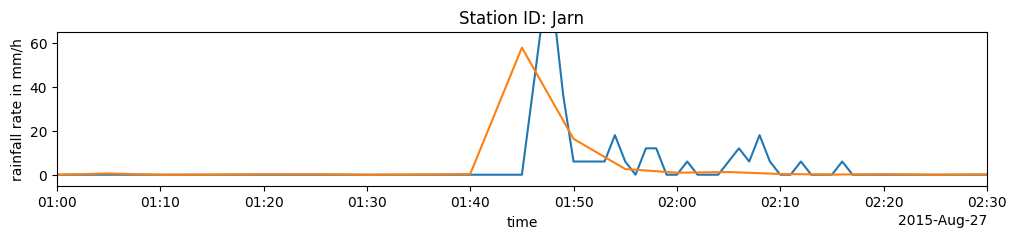

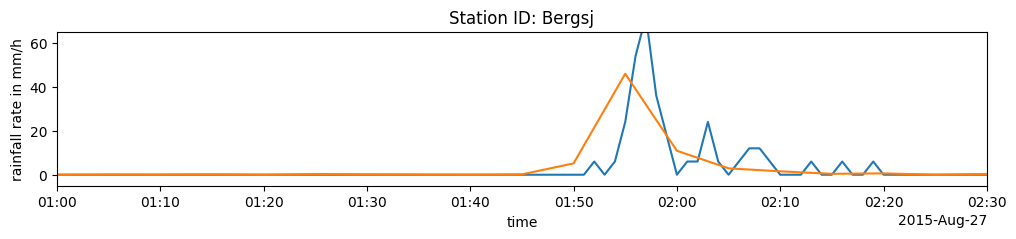

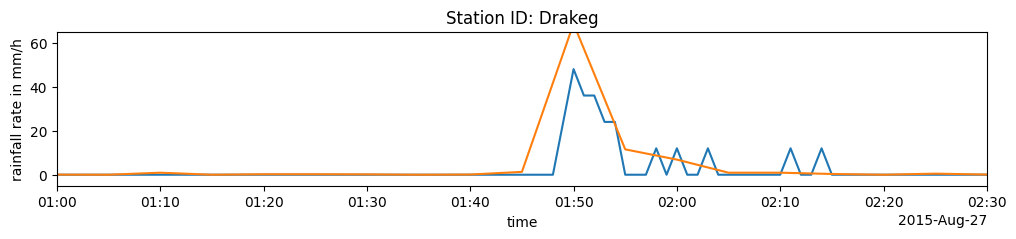

In [9]:
for i in [0, 2, 7]:
    (ds_city_gauges.isel(id=i).rainfall_amount * 60).plot(figsize=(12, 2))
    radar_at_points.isel(id=i).plot()
    plt.xlim(radar_at_points.time.data[0], radar_at_points.time.data[-1])
    plt.ylim(-5, 65)
    plt.ylabel('rainfall rate in mm/h')
    plt.title(f'Station ID: {ds_city_gauges.isel(id=i).station_id.data}')
    plt.show()

## Plot CML rain rates vs mean radar rain rate along CML

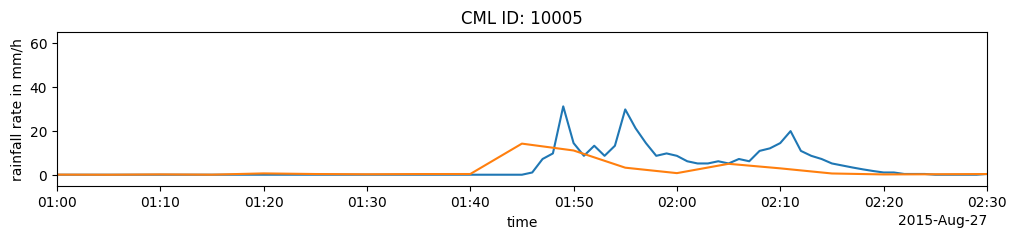

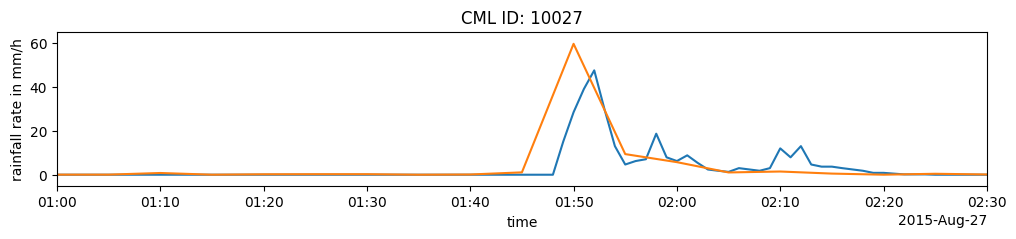

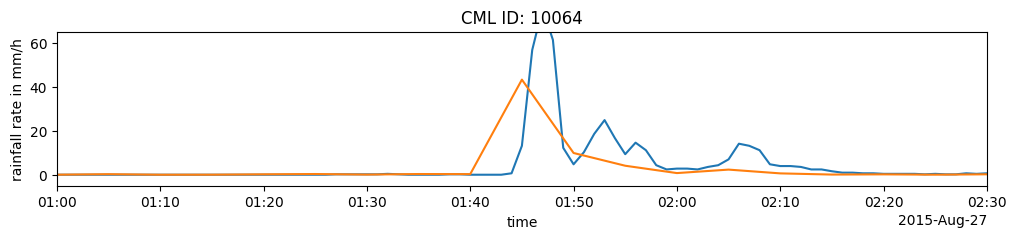

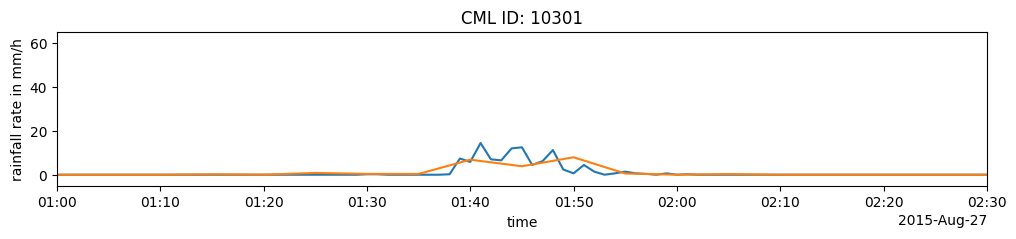

In [10]:
for i in [0, 10, 30, 210]:
    ds_cmls.isel(cml_id=i).R.plot(figsize=(12, 2))
    radar_along_cml.isel(cml_id=i).plot()
    plt.xlim(radar_along_cml.time.data[0], radar_along_cml.time.data[-1])
    plt.ylim(-5, 65)
    plt.ylabel('rainfall rate in mm/h')
    plt.title(f'CML ID: {ds_cmls.isel(cml_id=i).cml_id.data}')
    plt.show()